In [2]:
# Load .env variables in environment

%reload_ext dotenv
%dotenv

In [10]:
import hopsworks
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
from matplotlib import pyplot
from hsml.schema import Schema
from hsml.model_schema import ModelSchema
import joblib
import os

In [4]:
# You have to set the environment variable 'HOPSWORKS_API_KEY' for login to succeed
project = hopsworks.login()
fs = project.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/209044
Connected. Call `.close()` to terminate connection gracefully.


In [5]:
# The feature view is the input set of features for your model. The features can come from different feature groups.    
# You can select features from different feature groups and join them together to create a feature view
wine_fg = fs.get_feature_group(name="wine", version=2)
query = wine_fg.select_all()
feature_view = fs.get_or_create_feature_view(name="wine",
                                  version=1,
                                  description="Read from Wine dataset",
                                  labels=["quality"],
                                  query=query)

Feature view created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/209044/fs/208963/fv/wine/version/1


In [6]:
# You can read training data, randomly split into train/test sets of features (X) and labels (y)        
X_train, X_test, y_train, y_test = feature_view.train_test_split(0.2)

Finished: Reading data from Hopsworks, using ArrowFlight (1.53s) 


In [7]:
X_train

,type,volatile_acidity,chlorides,density,ph,sulphates,alcohol
1,0,0.33,0.047,0.99760,3.09,0.46,8.9
2,0,0.24,0.037,0.98914,2.96,0.36,12.5
3,1,0.71,0.080,0.99720,3.47,0.55,9.4
4,0,0.19,0.056,0.99950,3.20,0.44,8.8
5,0,0.34,0.035,0.99460,3.15,0.49,9.7
...,...,...,...,...,...,...,...
5256,0,0.16,0.033,0.99410,3.20,0.39,10.3
5257,0,0.38,0.035,0.98916,3.04,0.37,12.5
5258,1,0.62,0.084,0.99780,3.34,0.53,9.5
5259,1,0.71,0.092,0.99635,3.38,0.58,10.0


In [11]:
y_train

,quality
1,5
2,6
3,5
4,6
5,5
...,...
5256,4
5257,6
5258,5
5259,6


## Model training 

In [12]:
clf = Pipeline([
        ('clf', DecisionTreeClassifier(random_state=101))])  

# a list of dictionaries to specify the parameters that we'd want to tune
criterion = ['gini', 'entropy']
splitter = ['best']
max_depth = [8, 9, 10, 11] # [15, 20, 25]
min_samples_leaf = [2, 3, 5]
class_weight = ['balanced', None] 

param_grid =\
    [{ 'clf__class_weight': class_weight
      ,'clf__criterion': criterion
      ,'clf__splitter': splitter
      ,'clf__max_depth': max_depth
      ,'clf__min_samples_leaf': min_samples_leaf
}]

gs = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='accuracy', cv=5, verbose=1, n_jobs=-1)
DT = Pipeline([
        ('scl', StandardScaler()),
        ('gs', gs)
 ]) 

DT.fit(X_train,y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


Pipeline(steps=[('scl', StandardScaler()),
                ('gs',
                 GridSearchCV(cv=5,
                              estimator=Pipeline(steps=[('clf',
                                                         DecisionTreeClassifier(random_state=101))]),
                              n_jobs=-1,
                              param_grid=[{'clf__class_weight': ['balanced',
                                                                 None],
                                           'clf__criterion': ['gini',
                                                              'entropy'],
                                           'clf__max_depth': [8, 9, 10, 11],
                                           'clf__min_samples_leaf': [2, 3, 5],
                                           'clf__splitter': ['best']}],
                              scoring='accuracy', verbose=1))])

In [17]:
# Evaluate model performance using the features from the test set (X_test)
y_pred = DT.predict(X_test)

# Compare predictions (y_pred) with the labels in the test set (y_test)
metrics = classification_report(y_test, y_pred, output_dict=True)
results = confusion_matrix(y_test, y_pred)

In [18]:
print(metrics)

{'3': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 6}, '4': {'precision': 0.05, 'recall': 0.02040816326530612, 'f1-score': 0.02898550724637681, 'support': 49}, '5': {'precision': 0.5426356589147286, 'recall': 0.621301775147929, 'f1-score': 0.5793103448275863, 'support': 338}, '6': {'precision': 0.52, 'recall': 0.5934782608695652, 'f1-score': 0.5543147208121827, 'support': 460}, '7': {'precision': 0.4482758620689655, 'recall': 0.2988505747126437, 'f1-score': 0.3586206896551724, 'support': 174}, '8': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 25}, '9': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 1}, 'accuracy': 0.5090218423551757, 'macro avg': {'precision': 0.22298736014052772, 'recall': 0.21914839628506347, 'f1-score': 0.2173187517916169, 'support': 1053}, 'weighted avg': {'precision': 0.47774060086721587, 'recall': 0.5090218423551757, 'f1-score': 0.4887103114723653, 'support': 1053}}


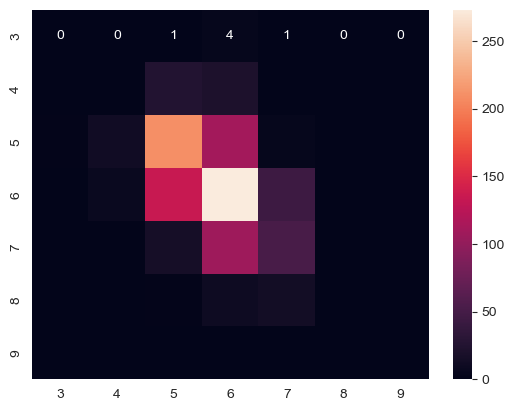

In [22]:
# Create the confusion matrix as a figure, we will later store it as a PNG image file
df_cm = pd.DataFrame(results, range(3,10), columns=range(3, 10))
cm = sns.heatmap(df_cm, annot=True)
fig = cm.get_figure()

In [13]:
# We will now upload our model to the Hopsworks Model Registry. First get an object for the model registry.
mr = project.get_model_registry()

# The contents of the 'iris_model' directory will be saved to the model registry. Create the dir, first.
model_dir="iris_model"
if os.path.isdir(model_dir) == False:
    os.mkdir(model_dir)

# Save both our model and the confusion matrix to 'model_dir', whose contents will be uploaded to the model registry
joblib.dump(model, model_dir + "/iris_model.pkl")
fig.savefig(model_dir + "/confusion_matrix.png")    

# Specify the schema of the model's input/output using the features (X_train) and labels (y_train)
input_schema = Schema(X_train)
output_schema = Schema(y_train)
model_schema = ModelSchema(input_schema, output_schema)

# Create an entry in the model registry that includes the model's name, desc, metrics
iris_model = mr.python.create_model(
    name="iris_model", 
    metrics={"accuracy" : metrics['accuracy']},
    model_schema=model_schema,
    description="Iris Flower Predictor"
)

# Upload the model to the model registry, including all files in 'model_dir'
iris_model.save(model_dir)

Connected. Call `.close()` to terminate connection gracefully.


  0%|          | 0/6 [00:00<?, ?it/s]

Model created, explore it at https://c.app.hopsworks.ai:443/p/209044/models/iris_model/1


Model(name: 'iris_model', version: 1)